In [63]:
import osmnx as ox
import pandas as pd
from pathlib import Path
import numpy as np
import src.geo_transform as gt
import networkx as nx
import src.wrangle_bbr as wrangle
ox.settings.log_console = True
ox.settings.use_cache=True

In [121]:
DATA_DIR = Path("data")
df = pd.read_csv(DATA_DIR / "gas_fjernvarme_distances.csv")

In [68]:
df.columns

Index(['ID', 'kommunekode', 'gas_x', 'gas_y', 'distance', 'fjernvarme_x',
       'fjernvarme_y'],
      dtype='object')

In [75]:
odsherred_id = 306
place = "Odsherred Municipality"
G = ox.graph_from_place(place, network_type="walk")

In [111]:
Gp = ox.project_graph(G, to_crs="epsg:25832")

In [125]:
odsherred_df = df[df["kommunekode"] == odsherred_id]

In [72]:
odsherred_df.columns

Index(['ID', 'kommunekode', 'gas_x', 'gas_y', 'distance', 'fjernvarme_x',
       'fjernvarme_y'],
      dtype='object')

In [122]:
df

,ID,kommunekode,gas_lat,gas_long,distance,fjernvarme_lat,fjernvarme_long
0,0a3f5090-a68c-32b8-e044-0003ba298018,621,55.430756,9.262525,182.048449,55.430545,9.265378
1,0a3f507d-a4b9-32b8-e044-0003ba298018,230,55.828152,12.536640,221.696775,55.829514,12.534060
2,0a3f5094-0318-32b8-e044-0003ba298018,730,56.430891,9.938340,439.560751,56.434790,9.937205
3,0a3f508f-7e22-32b8-e044-0003ba298018,766,55.787056,9.697808,733.776056,55.780671,9.700721
4,0a3f5082-3f88-32b8-e044-0003ba298018,269,55.530301,12.223541,62.081472,55.530839,12.223801
...,...,...,...,...,...,...,...
374557,0a3f5093-d578-32b8-e044-0003ba298018,710,56.279665,9.824877,555.152745,56.280540,9.833704
374558,0a3f5082-4647-32b8-e044-0003ba298018,269,55.523433,12.208271,91.571024,55.522772,12.207406
374559,0a3f5090-a2ca-32b8-e044-0003ba298018,621,55.405390,9.385652,3603.517402,55.417189,9.438655
374560,0a3f5094-3456-32b8-e044-0003ba298018,730,56.558118,10.109287,145.543761,56.559424,10.109188


In [124]:
df.columns

Index(['ID', 'kommunekode', 'gas_lat', 'gas_long', 'distance',
       'fjernvarme_lat', 'fjernvarme_long'],
      dtype='object')

In [130]:
gas_nodes, gasdists = ox.distance.nearest_nodes(G, df["gas_long"].tolist(), df["gas_lat"].tolist(), return_dist=True,)
fjern_nodes, dists = ox.distance.nearest_nodes(G, odsherred_df["fjernvarme_long"].tolist(), odsherred_df["fjernvarme_lat"].tolist(), return_dist=True,)

In [133]:
np.mean(gasdists)

75907.09022466769

In [110]:
odsherred_df["gas_x"]

2302      655883.190000
2754      654413.960000
3208      654399.860000
8446      654520.060000
101004    657348.910000
              ...      
352978    653796.230000
353488    656643.007837
353489    653784.180000
353490    653866.020000
371460    656559.250000
Name: gas_x, Length: 1816, dtype: float64

In [84]:
assert all(node in Gp.nodes for node in gas_nodes)
assert all(node in Gp.nodes for node in fjern_nodes)

In [85]:
4687643000 in Gp.nodes

True

In [93]:
#lengths = nx.shortest_path_length(G=Gp, source=gas_nodes, target=fjern_nodes, weight='length')

lengths = np.zeros(len(gas_nodes))
assert lengths.shape == (len(gas_nodes),)
for i, (gas, fjern) in enumerate(zip(gas_nodes, fjern_nodes)):
    length = nx.shortest_path_length(G=Gp, source=gas, target=fjern, weight='length')
    lengths[i] += length

In [101]:
node_colors = ["blue" if node in gas_nodes else "white" for node in Gp.nodes]


In [103]:
np.unique(gas_nodes)

array([4687643000], dtype=int64)

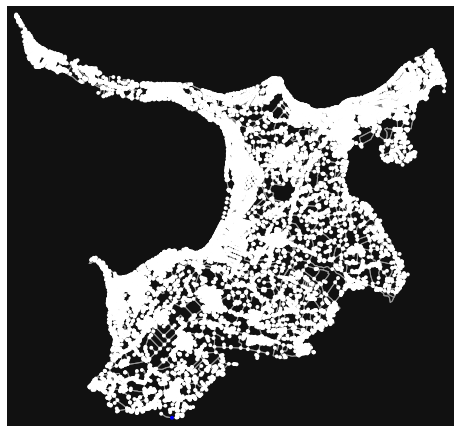

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [102]:
ox.plot_graph(Gp, node_color=node_colors)

In [95]:
odsherred_df["road_dist"] = lengths

C:\Users\jhr\AppData\Local\Temp\ipykernel_7056\1826409843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odsherred_df["road_dist"] = lengths


In [96]:
odsherred_df 

,ID,kommunekode,gas_x,gas_y,distance,fjernvarme_x,fjernvarme_y,road_dist
2302,a384d080-e49b-496d-af54-fe883e706bb8,306,655883.190000,655883.190000,305.318563,655732.34,6184279.85,7067.572
2754,0a3f5082-9cb4-32b8-e044-0003ba298018,306,654413.960000,654413.960000,156.518695,654281.03,6185203.07,7678.034
3208,0a3f5082-9cb4-32b8-e044-0003ba298018,306,654399.860000,654399.860000,148.716190,654281.03,6185203.07,7678.034
8446,47b90a10-9940-4568-848d-5f18f14a28f6,306,654520.060000,654520.060000,315.732994,654312.66,6185418.17,7974.166
101004,40afd2f5-fe2e-3373-e044-0003ba298018,306,657348.910000,657348.910000,605.259080,657078.67,6188153.95,12108.218
...,...,...,...,...,...,...,...,...
352978,0a3f5082-a52a-32b8-e044-0003ba298018,306,653796.230000,653796.230000,134.483861,653929.54,6181112.03,2399.282
353488,e5bf3d19-5a9c-4aaf-bb46-4afca88962c9,306,656643.007837,656643.007837,318.266749,656773.38,6188225.27,12320.238
353489,0a3f5082-a53c-32b8-e044-0003ba298018,306,653784.180000,653784.180000,188.098682,653929.54,6181112.03,2399.282
353490,0a3f5082-a549-32b8-e044-0003ba298018,306,653866.020000,653866.020000,129.786374,653929.54,6181112.03,2399.282
